In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math

# define the neural network
class PolicyNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# define the policy gradient agent
class PolicyGradientAgent:
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        self.policy_net = PolicyNet(input_size, hidden_size, output_size)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.policy_net(state)
        action_probs = torch.distributions.Categorical(probs)
        action = action_probs.sample()
        return action.item()
    
    def update_policy(self, rewards, log_probs):
        returns = []
        discount_factor = 0.99
        for i in range(len(rewards)):
            Gt = 0
            pw = 0
            for r in rewards[i:]:
                Gt = Gt + discount_factor**pw * r
                pw = pw + 1
            returns.append(Gt)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)
        policy_loss = []
        for log_prob, Gt in zip(log_probs, returns):
            policy_loss.append(-log_prob * Gt)
        self.optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()
    
    def print_prob(self,state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.policy_net(state)
        action_probs = torch.distributions.Categorical(probs)
        action = action_probs.sample()
        print(action.item())

In [20]:
def Payoff(price):
    return max(K-price,0)

In [21]:
u = 1.1
d = 1/u
p = 0.5
q = 1-p
N =  10
K = 100 
S0 = 100
r = 0.03
dt = 1/252

stock_price = np.zeros((N + 1, N + 1))
stock_price[0, 0] = S0

for i in range(1, N + 1):
    stock_price[i, 0] = stock_price[i-1, 0] * u
    for j in range(1, i + 1):
        stock_price[i, j] = stock_price[i-1, j-1] * d
        
states = []
Payoff_terminal = []
for i in range(len(stock_price)):
    for j in range(len(stock_price[0])):
        if stock_price[i][j] !=0:
            states.append([j,i])
        if i == N:
            Payoff_terminal.append(Payoff(stock_price[i][j]))
states = np.array(states)
        
Optimal_val = np.zeros(len(states))
Optimal_val[-(N+1):] = Payoff_terminal 
Optimal = {}
for i in range(len(states)):
    Optimal[str(states[i].tolist())] = Optimal_val[i]

In [22]:
for i, s in enumerate(np.flip(states)):
    if s[0]<N:      
        Optimal[str([s[1],s[0]])] = max(Payoff(stock_price[s[0]][s[1]]),(p*Optimal[str([s[1],s[0]+1])]+q*Optimal[str([s[1]+1,s[0]+1])])\
                                                    *np.exp(-dt*r))
Optimal

{'[0, 0]': 10.21295267455009,
 '[0, 1]': 6.2096148350309965,
 '[1, 1]': 14.218722314215023,
 '[0, 2]': 3.19605257938478,
 '[1, 2]': 9.224655658408077,
 '[2, 2]': 19.216174581617288,
 '[0, 3]': 1.2517527860535425,
 '[1, 3]': 5.141113382913198,
 '[2, 3]': 13.310394411228398,
 '[3, 3]': 25.126530304017354,
 '[0, 4]': 0.2839218576772182,
 '[1, 4]': 2.219881768548463,
 '[2, 4]': 8.063569144757388,
 '[3, 4]': 18.560389007872754,
 '[4, 4]': 31.698654463492943,
 '[0, 5]': 0,
 '[1, 5]': 0.5679113198207361,
 '[2, 5]': 3.8723807920165747,
 '[3, 5]': 12.25667750919776,
 '[4, 5]': 24.86851990984222,
 '[5, 5]': 37.907867694084494,
 '[0, 6]': 0,
 '[1, 6]': 0,
 '[2, 6]': 1.135957864671331,
 '[3, 6]': 6.609725769671347,
 '[4, 6]': 17.906547678986623,
 '[5, 6]': 31.69865446349293,
 '[6, 6]': 43.552606994622266,
 '[0, 7]': 0,
 '[1, 7]': 0,
 '[2, 7]': 0,
 '[3, 7]': 2.272186211600732,
 '[4, 7]': 10.948839165651805,
 '[5, 7]': 24.868519909842206,
 '[6, 7]': 37.90786769408448,
 '[7, 7]': 48.68418817692933,
 

In [23]:
class American_easy:
    def __init__(self):
        self.reset()

    def reset(self):
        #self.state = 0
        self.state = [100,0,0.0,5,0]

    def step(self,action):
        price = self.state[0]
        t = self.state[1]
        delta = self.state[2]
        cash = self.state[3]
        out_bound = self.state[4]
        price_new = price*u if np.random.rand() < p else price*d
        num_of_d = int(-round(math.log((price_new / S0),u)) /2 +(t+1)/2)
        pay_off = Optimal[str([num_of_d,t+1])] 
        #print(num_of_d,pay_off,price_new)
        action_new = -1+action/100 # from categorical action to real action
        delta_new = delta + action_new 
        if delta_new>1:
            delta_new = 1
            out_bound = 1
        elif delta_new<-1:
            delta_new = -1
            out_bound = 1
        cash -= (delta_new-delta)*price
        cash *= np.exp(dt*r)
        reward = (pay_off-delta_new*price_new-cash)**2
        self.state = [price_new,t+1,delta_new,cash,out_bound]
        if t+1<N:
            return self.state,-reward,False,
        else:
            return self.state,-reward,True

In [24]:
env = American_easy()
input_size = np.shape(env.state)[0]
output_size = 200

In [25]:
agent = PolicyGradientAgent(input_size, 128, output_size, 0.001)

# train the agent
total_reward = []
average_reward = []
action_arr = []
for episode in range(10000):
    env.reset()
    state = np.array(env.state)
    done = False
    rewards = []
    log_probs = []
    while not done:
        action = agent.get_action(state)
        action_arr.append(action)
        next_state, reward, done = env.step(action)
        rewards.append(reward)
        log_probs.append(torch.log(agent.policy_net(torch.from_numpy(state).float().unsqueeze(0))[0][action]))
        state = np.array(next_state)
    agent.update_policy(rewards, log_probs)
    total_reward.append(sum(rewards))
    
    if episode < 100:
        avg_list = total_reward[:episode+1]
    else:
        avg_list = total_reward[episode-99:episode+1]
    average_reward.append(np.average(avg_list))
    if episode % 1000 == 0:
        print("Episode {}: {}".format(episode, sum(rewards)))

Episode 0: -2394.040554097308
Episode 1000: -115.26261004482566
Episode 2000: -7317.439240194839
Episode 3000: -1085.3090883337243
Episode 4000: -598.1446192660587
Episode 5000: -862.2244056584954
Episode 6000: -560.8762063679651
Episode 7000: -447.6866453518742
Episode 8000: -5858.228289312467
Episode 9000: -728.1225581811735


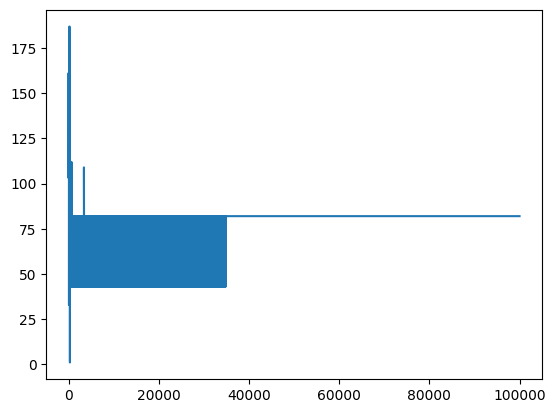

In [26]:
plt.plot(action_arr,label = 'action')

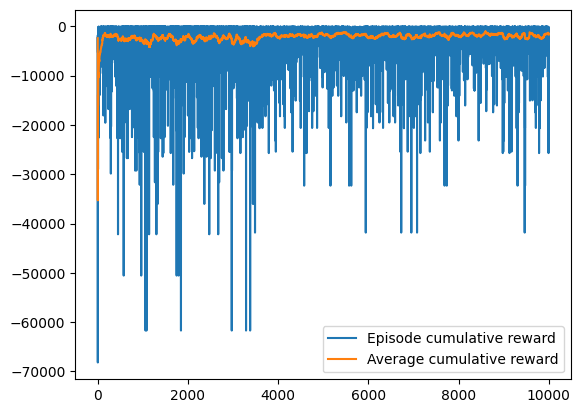

In [27]:
import matplotlib.pyplot as plt
plt.plot(total_reward,label = 'Episode cumulative reward')
plt.plot(average_reward,label = 'Average cumulative reward')
plt.legend()

In [28]:
env.reset()
state = np.array(env.state)
action = agent.get_action(state)
next_state, reward, done = env.step(action)
print(action)
state = np.array(next_state)
action = agent.get_action(state)
next_state, reward, done = env.step(action)
print(action)

82
82
